In [2]:
## Loading package
import os
import torch
import anndata
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
os.environ['R_HOME'] = 'E:/R-4.3.1'
os.environ['R_USER'] = 'E:/anaconda/lib/site-packages/rpy2'

from model import DCCAE
from preprocess import preprocessing
from preprocess import fix_seed
import numpy as np
import warnings
# 过滤掉所有警告
warnings.filterwarnings('ignore')

adata_modality_1 = sc.read_h5ad("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Brain_H3K27me3/adata_RNA.h5ad")
adata_modality_2 = sc.read_h5ad("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Brain_H3K27me3/adata_peaks_normalized.h5ad")

adata_modality_1.var_names_make_unique()
adata_modality_2.var_names_make_unique()

e:\anaconda\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
e:\anaconda\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
e:\anaconda\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
e:\anaconda\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
e:\anaconda\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
e:\anaconda\Lib\site-packages\anndata\utils.py:429: 

In [3]:
fix_seed(2024)
adata_modality_1, adata_modality_2 = preprocessing(adata_modality_1, adata_modality_2, 'Spatial-epigenome-transcriptome')
adata_modality_1.X = adata_modality_1.uns['INR']
adata_modality_2.obsm['X_pca'] = adata_modality_2.uns['INR']
sc.pp.pca(adata_modality_1)

Spatial-epigenome-transcriptome data preprocessing have done!
Dimensions after preprocessed adata_modal_1: (9732, 3000)
Dimensions after preprocessing adata_modal_2: (9732, 70470)


In [4]:
# Define parameters and layers for deep model
# n_output = 20, n_DCCA = 20, epochs = 60, resolution = 0.7, use_rep=use_rep[1]
# n_output = 30, n_DCCA = 10, epochs = 60, resolution = 0.6, use_rep=use_rep[2]
# n_output = 30, n_DCCA = 10, epochs = 60, resolution = 0.42, use_rep=use_rep[0]
# n_output = 30, n_DCCA = 10, epochs = 60, resolution=0.355, use_rep=use_rep[0]
n_output = 30
features1 = adata_modality_1.obsm['X_pca'].shape[1]  # Feature sizes
features2 = adata_modality_2.obsm['X_pca'].shape[1]
layers1 = [256, 256, n_output]  # nodes in each hidden layer and the output size
layers2 = [256, 256, n_output]

X = adata_modality_1.obsm['X_pca']
Y = adata_modality_2.obsm['X_pca']

use_rep = ['DCCAE_X', "DCCAE_Y", "DCCAE"]
n_DCCA = 10
epochs = 60
model = DCCAE(input_size1=features1, input_size2=features2, n_components=n_DCCA, layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=epochs)
model.fit([X, Y])
Xs_transformed = model.transform([X, Y])
adata_modality_1.obsm["DCCAE_X"] =  Xs_transformed[0]
adata_modality_2.obsm["DCCAE_Y"] =  Xs_transformed[1]
adata_modality_1.obsm["DCCAE"] = np.concatenate((adata_modality_1.obsm["DCCAE_X"], adata_modality_2.obsm["DCCAE_Y"]),axis=1)

Training Progress: 100%|██████████| 60/60 [00:31<00:00,  1.90it/s]


model training finished!


In [136]:
# 切片需要顺时针旋转90度
coordinates = adata_modality_1.obsm['spatial']

# 旋转90度（顺时针）
rotated_coordinates = np.zeros_like(coordinates)  # 创建一个同样形状的数组用于存放旋转后的坐标
rotated_coordinates[:, 0] = -coordinates[:, 1]  # 新的x坐标是原始的y坐标取反
rotated_coordinates[:, 1] = coordinates[:, 0]  # 新的y坐标是原始的x坐标

adata_modality_1.obsm['spatial'] = rotated_coordinates

# 切片需要顺时针旋转90度
coordinates = adata_modality_2.obsm['spatial']

# 旋转90度（顺时针）
rotated_coordinates = np.zeros_like(coordinates)  # 创建一个同样形状的数组用于存放旋转后的坐标
rotated_coordinates[:, 0] = -coordinates[:, 1]  # 新的x坐标是原始的y坐标取反
rotated_coordinates[:, 1] = coordinates[:, 0]  # 新的y坐标是原始的x坐标

adata_modality_2.obsm['spatial'] = rotated_coordinates

In [32]:
adata_modality_1.obs["clusters_leiden"]

CTAAGGTCAACGTGAT    4
CTAAGGTCACAAGCTA    1
CTAAGGTCTTGCTGGA    5
CTAAGGTCCTGTAGCC    1
CTAAGGTCAGTACAAG    1
                   ..
GAACAGGCGATGAATC    8
GAACAGGCGCCAAGAC    8
GAACAGGCCGGAAGAA    8
GAACAGGCGTGACAAG    8
GAACAGGCGAACCAGA    8
Name: clusters_leiden, Length: 9732, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

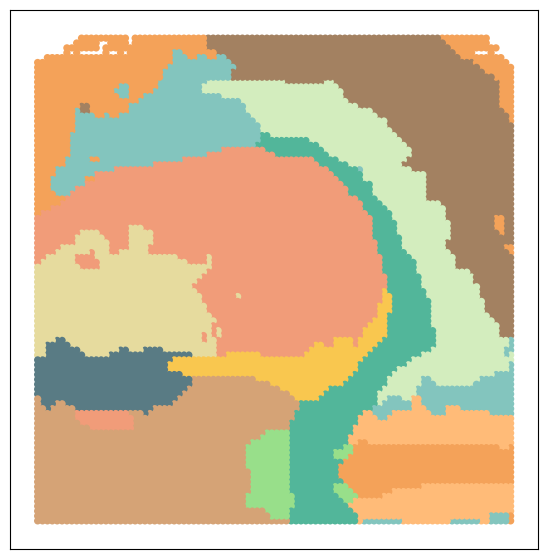

In [ ]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
colors = [
    '#F19C79', '#a38161', '#d5a376', '#d3edbe', '#f4a259', '#83c5be', '#e6db9e','#52b69a',
    '#ffbb78', '#597b84', '#f9c74f', '#98df8a'
]
sc.pp.neighbors(adata_modality_1, use_rep=use_rep[2])
sc.tl.leiden(adata_modality_1, key_added="clusters_leiden", resolution=0.52)
sc.pl.spatial(adata_modality_1, img_key="hires", color=["clusters_leiden"], spot_size=1.5, ax=ax, show=False, palette=colors)
ax.invert_yaxis()
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
# remove legend
ax.get_legend().remove()

In [33]:
## obs store the clustering results
## uns store the integrated embeddings
# adata_SpaKnit = anndata.AnnData()
adata_analysis = sc.read_h5ad("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Mouse_Brain_H3K27me3.h5ad")
adata_analysis.obs['SpaKnit'] = adata_modality_1.obs['clusters_leiden']
adata_analysis.obsm['SpaKnit'] = adata_modality_1.obsm['DCCAE']
# adata_analysis.obsm['spatial'] = adata_modality_1.obsm['spatial']
adata_analysis.write_h5ad('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Mouse_Brain_H3K27me3.h5ad')

In [34]:
## calculate the marker genes
sc.tl.dendrogram(adata_modality_1, groupby='clusters_leiden')
sc.tl.rank_genes_groups(adata_modality_1, groupby='clusters_leiden', use_raw=False)

rank_genes = sc.get.rank_genes_groups_df(adata_modality_1, group=None)
rank_genes.to_excel("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Visualization/Mouse_Brain/H3K27me3/" + 'H3K27me3_marker_genes.xlsx', index=True)